<a href="https://colab.research.google.com/github/w12l3-c/EMG-Fabric/blob/main/EMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMG Fabric ML Model
Made by Wallace Lee

Right now the Rock Paper Scissors ML is Pretty Good

For the Grasping motion that we collect data from, there is no point of using ML prediction as we can simply use a if value > threshold = grapse. But when we have multiple channels of EMG data then ML would be useful.

# Dataset

In [128]:
# Kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [129]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wallacel","key":"d4846c13171812a348c366972bd73a6b"}'}

In [131]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kyr7plus/emg-4

100% 868k/868k [00:00<00:00, 1.25MB/s]
100% 868k/868k [00:00<00:00, 1.25MB/s]


In [132]:
! mkdir dataset
! unzip -d dataset emg-4.zip

Archive:  emg-4.zip
  inflating: dataset/0.csv           
  inflating: dataset/1.csv           
  inflating: dataset/2.csv           
  inflating: dataset/3.csv           


In [1]:
# Clone lead's github repo to get access to collected datasets
!pip install git
!git clone https://github.com/jacq-lee/emgFabric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement git (from versions: none)
ERROR: No matching distribution found for git
Cloning into 'emgFabric'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 51 (delta 15), reused 39 (delta 9), pack-reused 0
Unpacking objects: 100% (51/51), 46.79 KiB | 424.00 KiB/s, done.


In [2]:
%matplotlib inline
import scipy as sp
from scipy import signal

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Signal Processing & Prepare Dataset

In [4]:
def clean_data(path, stop):
  data = np.loadtxt(path, dtype=int)
  data = np.abs(np.diff(data))
  num_sample = data.size
  time = np.zeros((num_sample,), int)
  sample_rate = np.reciprocal(np.divide(stop, num_sample))
  return data, sample_rate

In [106]:
def stop_time(path):
  time = np.loadtxt(path)
  time = time[-1]
  return time

In [112]:
trial_root = "/content/emgFabric/Arduino EMG Data"
trials = ['trial1.txt', 'trial2.txt', 'trial3.txt', 'trial4.txt', 'trial5.txt']
time_stop = ["trial1_contraction_times.txt", "trial2_contraction_times.txt", "trial3_contraction_times.txt", "trial4_contraction_times.txt", "trial5_contraction_times.txt"]

In [107]:
stop = []
for path in time_stop:
  ts = stop_time(os.path.join(trial_root, path))
  stop.append(ts)

nps = []
s_rates = []

for i, path in enumerate(trials):
  data, s_rate = clean_data(os.path.join(trial_root, path), stop[i])
  nps.append(data)
  s_rates.append(s_rate)

In [7]:
# An example
trial2_path = "/content/emgFabric/Arduino EMG Data/trial2.txt"
trail2_stop = 67.61

(t2_data, s_rate) = clean_data(trial2_path, trail2_stop)

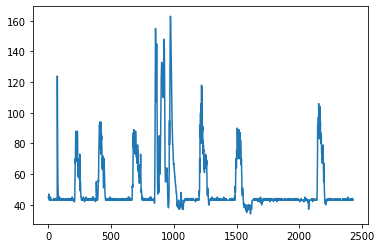

In [8]:
plt.plot(t2_data)

In [9]:
def filter_data(data, s_rate):
  nyquist_f = s_rate/2
  high = 0.75/nyquist_f
  low = 15/nyquist_f
  b, a = signal.butter(4, [high, low], btype='bandpass')
  emg_filtered = signal.filtfilt(b, a, data, axis=0)
  emg_rectified = np.abs(emg_filtered)
  low_pass = 0.5/nyquist_f
  print(nyquist_f)
  b2, a2 = signal.butter(4, low_pass, btype='lowpass')
  emg_envelop = signal.filtfilt(b2, a2, emg_rectified, axis=0)
  return emg_envelop

In [119]:
emg_envelops = []
for i, data in enumerate(nps):
  emg_envelop = filter_data(data, s_rates[i])
  emg_envelops.append(emg_envelop)

17.050298380221655
17.955923679929004
20.979349186483102
17.669872789326714
17.636632200886265


17.955923679929004


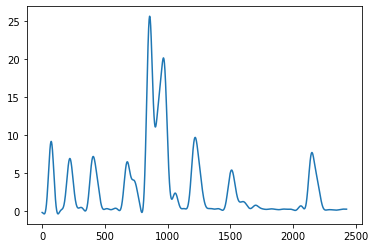

In [10]:
# An example
emg_envelop = filter_data(t2_data, s_rate)

plt.plot(emg_envelop)

In [120]:
emgs = []
emg = pd.DataFrame()
labelling = emg.copy()
thres = 2     # hyperparam to tune

for emg_envelop in emg_envelops:
  emg = pd.DataFrame(emg_envelop)
  labelling = emg.copy()
  labelling.iloc[:, 0] = labelling.iloc[:, 0].apply((lambda x: 1 if x > thres else 0))
  emg[1] = labelling
  emg = emg.rename({0: 'Value', 1: 'Label'}, axis=1)
  emgs.append(emg)

emg = pd.concat(emgs) # the emg df is prepared

In [121]:
emg

,Value,Label
0,-0.066436,0
1,0.018802,0
2,0.101680,0
3,0.181885,0
4,0.259121,0
...,...,...
2383,3.676107,1
2384,3.684147,1
2385,3.690184,1
2386,3.694602,1


# Machine Learning for Kaggle

In [133]:
root = "/content/dataset"
dfs = []
dir = os.listdir(root)
dir.sort()
for path in dir:
  df = pd.read_csv(os.path.join(root, path), header=None)
  dfs.append(df)

df = pd.concat(dfs)

pose0df = pd.read_csv(os.path.join(root, '0.csv'))
pose1df = pd.read_csv(os.path.join(root, '1.csv'))
pose2df = pd.read_csv(os.path.join(root, '2.csv'))
pose3df = pd.read_csv(os.path.join(root, '3.csv'))

In [ ]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0


In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,50.872079,53.233589,48.150624,57.130963,56.732816,48.773137,49.697000,50.133133,46.132509,54.421273,...,49.559823,52.507151,47.392198,54.617758,60.308386,58.635725,48.287941,50.049095,49.627723,49.159723
std,8.179167,6.065401,7.447678,5.724366,8.380470,10.365272,9.839205,6.066494,7.647196,5.060368,...,9.918824,6.264047,7.491549,5.152449,6.626344,5.907528,8.376281,10.020032,9.905779,6.187287
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.136564,51.546392,44.776119,54.615385,52.112676,42.971888,47.843137,47.244094,42.616034,52.991453,...,47.843137,49.586777,44.032922,53.218884,57.333333,56.000000,43.661972,44.705882,47.843137,46.215139
50%,50.660793,53.092784,47.761194,56.923077,56.807512,48.594378,49.803922,50.000000,45.991561,54.273504,...,49.803922,52.479339,47.325103,54.506438,60.000000,58.400000,48.356808,49.803922,49.803922,49.003984
75%,54.185022,55.154639,52.238806,60.000000,61.502347,54.216867,51.764706,52.755906,48.945148,55.982906,...,51.372549,55.371901,50.205761,56.223176,64.000000,61.600000,53.051643,55.294118,51.372549,51.792829
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [ ]:
print(f"Everything: ({df.shape[0]},{df.shape[1]})")
print(f"Pose 0: ({pose0df.shape[0]},{pose0df.shape[1]})")
print(f"Pose 1: ({pose1df.shape[0]},{pose1df.shape[1]})")
print(f"Pose 2: ({pose2df.shape[0]},{pose2df.shape[1]})")
print(f"Pose 3: ({pose3df.shape[0]},{pose3df.shape[1]})")

Everything: (11678,65)
Pose 0: (2909,65)
Pose 1: (2902,65)
Pose 2: (2942,65)
Pose 3: (2921,65)


In [ ]:
# preprocess for LGBM 
# don't use MinMax for DNN
scaler = preprocessing.MinMaxScaler((0, 100))
scaler.fit(df.iloc[:, :-1])
df.iloc[:, :-1] = scaler.transform(df.iloc[:, :-1])

In [134]:
df = shuffle(df)

In [135]:
y = df.iloc[:, -1].copy()
del df[df.columns[-1]]

In [136]:
xtrain, xtest, ytrain, ytest = train_test_split(df, y, test_size=0.2, random_state=42)

In [137]:
print(f"Train X: ({xtrain.shape[0]},{xtrain.shape[1]})")
print(f"Train Y: {ytrain.shape}")
print(f"Test X: ({xtest.shape[0]},{xtest.shape[1]})")
print(f"Test Y: {ytest.shape}")

Train X: (9342,64)
Train Y: (9342,)
Test X: (2336,64)
Test Y: (2336,)


In [138]:
# one-hot for K-Nearest
dummy = pd.get_dummies(ytrain)
dummy2 = pd.get_dummies(ytest)

# ML Models Training

Base on this article [Paper](http://pen.ius.edu.ba/index.php/pen/article/view/1293/602 )

In [144]:
#@title LightBGM
import lightgbm as lgb

In [145]:
clf = lgb.LGBMClassifier()
clf.fit(xtrain, ytrain)

LGBMClassifier()

In [146]:
ypred = clf.predict(xtest)

In [ ]:
#@title K-Nearest and Weighted K-Nearest
neigh = KNeighborsClassifier()
neigh.fit(xtrain, dummy)

KNeighborsClassifier()

In [ ]:
ypred2 = neigh.predict(xtest)

In [139]:
#@title DNN
# Input layer
input_layer = layers.Input(shape=(64,))

# Hidden layer
hidden_layer1 = layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(input_layer)
dropout_layer1 = layers.Dropout(0.5)(hidden_layer1)
bnorm_layer1 = layers.BatchNormalization()(dropout_layer1)
hidden_layer2 = layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(bnorm_layer1)
dropout_layer2 = layers.Dropout(0.5)(hidden_layer2)
bnorm_layer2 = layers.BatchNormalization()(dropout_layer2)
hidden_layer3 = layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(bnorm_layer2)
dropout_layer3 = layers.Dropout(0.5)(hidden_layer3)
bnorm_layer3 = layers.BatchNormalization()(dropout_layer3)
hidden_layer4 = layers.Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(bnorm_layer3)

# Output layer
output_layer = layers.Dense(units=4, activation='softmax')(hidden_layer3)

# Create the model
Model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="EMG")

In [140]:
class CallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("accuracy") is not None):
      if (logs.get("accuracy") == 0.90):
        print("Model stop training")
        self.model.stop_training = True

In [141]:
Model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [142]:
Model.summary()

Model: "EMG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                               

In [143]:
history = Model.fit(xtrain, ytrain, epochs=30, verbose=1, callbacks=[CallBack()])

Epoch 1/30
292/292 [==============================] - 9s 13ms/step - loss: 4.3726 - accuracy: 0.4203
Epoch 2/30
292/292 [==============================] - 3s 11ms/step - loss: 2.3174 - accuracy: 0.5773
Epoch 3/30
292/292 [==============================] - 3s 12ms/step - loss: 1.5310 - accuracy: 0.6737
Epoch 4/30
292/292 [==============================] - 6s 19ms/step - loss: 1.2451 - accuracy: 0.7296
Epoch 5/30
292/292 [==============================] - 3s 11ms/step - loss: 1.1508 - accuracy: 0.7399
Epoch 6/30
292/292 [==============================] - 2s 6ms/step - loss: 1.0969 - accuracy: 0.7572
Epoch 7/30
292/292 [==============================] - 2s 6ms/step - loss: 1.0487 - accuracy: 0.7725
Epoch 8/30
292/292 [==============================] - 2s 6ms/step - loss: 1.0427 - accuracy: 0.7734
Epoch 9/30
292/292 [==============================] - 3s 9ms/step - loss: 1.0279 - accuracy: 0.7825
Epoch 10/30
292/292 [==============================] - 2s 7ms/step - loss: 0.9995 - accuracy: 0

In [ ]:
prediction = Model.predict(xtest)

73/73 [==============================] - 0s 3ms/step


In [ ]:
prediction = np.argmax(prediction, axis=1)

In [ ]:
print(prediction)

[2 1 3 ... 3 1 2]


In [ ]:
Model = None

# Eval

In [ ]:
#@title Functions
def plot_cm(ytest, pred):
  cm = confusion_matrix(ytest, pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot()
  plt.grid(False)
  plt.show()

def class_report(ytest, pred, name):
  print(f'{name} accuracy score: {accuracy_score(ytest, ypred)}')
  print(classification_report(ytest, ypred, target_names=target_names))

In [ ]:
#@title LGBM
target_names = ['Pos0', 'Pos1', 'Pos2', 'Pos3']
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(ytest, ypred)))
print(classification_report(ytest, ypred, target_names=target_names))

LightGBM Model accuracy score: 0.9533
              precision    recall  f1-score   support

        Pos0       0.98      0.99      0.98       589
        Pos1       0.96      0.95      0.95       563
        Pos2       0.93      0.95      0.94       554
        Pos3       0.95      0.93      0.94       630

    accuracy                           0.95      2336
   macro avg       0.95      0.95      0.95      2336
weighted avg       0.95      0.95      0.95      2336



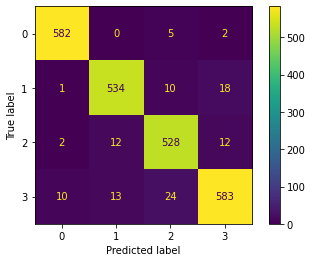

In [ ]:
cm = confusion_matrix(ytest, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.grid(False)
plt.show()

In [ ]:
#@title K-Near
print('K-Nearest Model accuracy score: {0:0.4f}'.format(accuracy_score(dummy2, ypred2)))
print(classification_report(dummy2, ypred2, target_names=target_names))

K-Nearest Model accuracy score: 0.6396
              precision    recall  f1-score   support

        Pos0       0.99      0.74      0.84       589
        Pos1       0.59      0.92      0.72       563
        Pos2       0.83      0.13      0.23       554
        Pos3       0.66      0.74      0.70       630

   micro avg       0.71      0.64      0.67      2336
   macro avg       0.77      0.63      0.62      2336
weighted avg       0.77      0.64      0.63      2336
 samples avg       0.64      0.64      0.64      2336



In [ ]:
ypred2 = np.argmax(ypred2, axis=1)

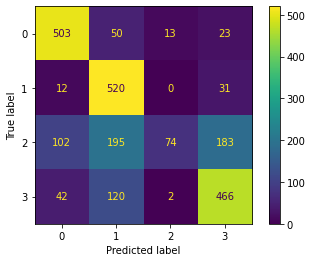

In [ ]:
cm = confusion_matrix(ytest, ypred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.grid(False)
plt.show()

In [ ]:
#@title DNN
print('Deep Neural Net accuracy score: {0:0.4f}'.format(accuracy_score(ytest, prediction)))
print(classification_report(ytest, prediction, target_names=target_names))

Deep Neural Net accuracy score: 0.9277
              precision    recall  f1-score   support

        Pos0       0.99      0.94      0.96       594
        Pos1       0.92      0.96      0.94       565
        Pos2       0.91      0.90      0.91       600
        Pos3       0.90      0.91      0.90       577

    accuracy                           0.93      2336
   macro avg       0.93      0.93      0.93      2336
weighted avg       0.93      0.93      0.93      2336



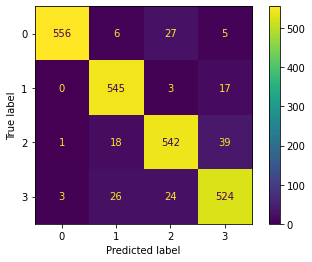

In [ ]:
cm = confusion_matrix(ytest, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.grid(False)
plt.show()

# Conclusion
<sup><sub>K-near is shit, LGBM is god<br>
DNN is even more shit<br>
Actually I am shit, I forget to preprocess it :))))))) DNN is decent</sub></sup>

### Ranking:
1. LGBM
2. DNN
3. KNN

In [147]:
# save lgbm
clf.booster_.save_model('lgbm.txt')
model = lgb.Booster(model_file='lgbm.txt')

In [150]:
# save DNN
Model.save("emg.h5")
new_model = tf.keras.models.load_model('/content/emg.h5')

# Transfer Learning with DNN

In [151]:
emg = shuffle(emg)
Y = emg.iloc[:, 1]
X = emg.iloc[:, 0]

In [212]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.1, random_state=42)

In [173]:
base_model = tf.keras.models.load_model('emg.h5')

In [174]:
base_model = tf.keras.models.Sequential(base_model.layers[1:-1])  # remove Input and Output Layer

In [178]:
base_model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [179]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [175]:
for layer in base_model.layers:
  layer.trainable = False

In [155]:
global_avg = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [190]:
input = tf.keras.Input(shape=(1,))
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(input)
x = base_model(x)
x = global_avg(x)
output = prediction_layer(x)

tmodel = tf.keras.Model(input, output, name="EMG")

In [191]:
tmodel.summary()

Model: "EMG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_11 (Dense)            (None, 64)                128       
                                                                 
 sequential (Sequential)     multiple                  100928    
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 102,113
Trainable params: 1,185
Non-trainable params: 100,928
_________________________________________________________________


In [192]:
tmodel.compile(optimizer='adam', loss=keras.losses.MAE, metrics=['accuracy'])

In [193]:
tmodel.fit(xtrain, ytrain, epochs=20, verbose=1, callbacks=[CallBack()])

Epoch 1/20
354/354 [==============================] - 3s 5ms/step - loss: 1.0031 - accuracy: 0.7331
Epoch 2/20
354/354 [==============================] - 2s 5ms/step - loss: 0.8035 - accuracy: 0.8616
Epoch 3/20
354/354 [==============================] - 2s 5ms/step - loss: 0.7339 - accuracy: 0.9138
Epoch 4/20
354/354 [==============================] - 3s 7ms/step - loss: 0.7013 - accuracy: 0.9304
Epoch 5/20
354/354 [==============================] - 2s 5ms/step - loss: 0.6855 - accuracy: 0.9351
Epoch 6/20
354/354 [==============================] - 2s 5ms/step - loss: 0.6771 - accuracy: 0.9365
Epoch 7/20
354/354 [==============================] - 2s 5ms/step - loss: 0.6680 - accuracy: 0.9364
Epoch 8/20
354/354 [==============================] - 2s 5ms/step - loss: 0.6600 - accuracy: 0.9412
Epoch 9/20
354/354 [==============================] - 2s 5ms/step - loss: 0.6622 - accuracy: 0.9383
Epoch 10/20
354/354 [==============================] - 2s 5ms/step - loss: 0.6566 - accuracy: 0.9376

In [195]:
tmodel.evaluate(xtest, ytest)

40/40 [==============================] - 1s 6ms/step - loss: 0.5907 - accuracy: 0.9531


[0.5907437801361084, 0.9531001448631287]

In [194]:
prediction = tmodel.predict(xtest)

40/40 [==============================] - 0s 4ms/step


In [199]:
prediction = pd.DataFrame(prediction)
prediction[0] = prediction[0].apply(lambda x: 1 if x >= 0.5 else 0)

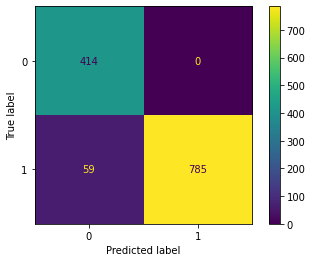

In [200]:
cm = confusion_matrix(ytest, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.grid(False)
plt.show()

# LGBM on Our own Data

In [214]:
model = lgb.LGBMClassifier()
xtrain = pd.DataFrame(np.array(xtrain).reshape(-1, 1))
model.fit(xtrain, ytrain)

LGBMClassifier()

In [216]:
xtest = pd.DataFrame(np.array(xtest).reshape(-1, 1))
ypred = model.predict(xtest)

In [217]:
target_names = ['0', '1']
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(ytest, ypred)))
print(classification_report(ytest, ypred, target_names=target_names))

LightGBM Model accuracy score: 0.9992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       414
           1       1.00      1.00      1.00       844

    accuracy                           1.00      1258
   macro avg       1.00      1.00      1.00      1258
weighted avg       1.00      1.00      1.00      1258



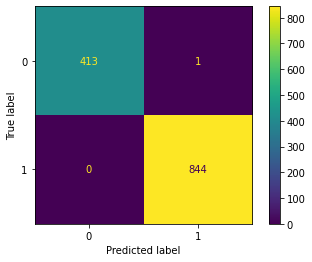

In [219]:
cm = confusion_matrix(ytest, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.grid(False)
plt.show()